In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7127376141095887022, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9223152599
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12387059694558660741
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import os
import numpy as np
np.random.seed(777)

from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import plot_model
from keras.optimizers import SGD, Adam, RMSprop

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.1.6
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
output_classes = 2
batch_size = 8
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = 59168
nb_validation_samples = 18384
nb_test_samples = 967

In [6]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test'

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59168 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [8]:
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
rmsp_opt = RMSprop(lr=1e-4, decay=0.9)

In [9]:
# for i, layer in enumerate(NasNetLarge_model.layers):
#     print(i, layer.name)

In [10]:
NasNetLarge_model = load_model('models/5.NASNetLarge-new-ISBI19-Model.h5', compile=False)
NasNetLarge_model = Model(inputs= NasNetLarge_model.input,outputs = NasNetLarge_model.get_layer('dense_3').output, name='NasNetLarge_model')

In [11]:
# InceptionResNetV2_model = load_model('models/5.InceptionResNetV2-ISBI19-Model.h5')
# InceptionResNetV2_model = Model(inputs=resnet_model.input,outputs=resnet_model.get_layer('dense_2').output,name='InceptionResNetV2_model')

In [12]:
# DenseNet201_model = load_model('models/12.DenseNet201-ISIB19-DataSet-Model.h5')
# DenseNet201_model = Model(inputs=DenseNet201_model.input, outputs=DenseNet201_model.get_layer('dense_3').output, name='DenseNet201_model')

In [13]:
# InceptionV3_model = load_model('models/9.InceptionV3-ISIB19-DataSet-Model.h5')
# InceptionV3_model = Model(inputs = InceptionV3_model.input,outputs = InceptionV3_model.get_layer('dense_3').output, name='InceptionV3_model')

In [14]:
VGG19_model = load_model('models/11.VGG19-ISBI19-Model.h5')
VGG19_model = Model(inputs = VGG19_model.input,outputs = VGG19_model.get_layer('dense_3').output, name='VGG19_model')

In [15]:
img = Input(shape=(224, 224,3),name='img')

feature1=NasNetLarge_model(img)
# feature2=InceptionV3_model(img)

# for layer in InceptionV3_model.layers[:300]:  
#     layer.trainable = False 
# for layer in InceptionV3_model.layers[300:]:  
#     layer.trainable = True  

feature3=VGG19_model(img)
# for layer in VGG19_model.layers[:170]:  
#     layer.trainable = False 
# for layer in VGG19_model.layers[170:]:  
#     layer.trainable = True  

# x = concatenate([feature1,feature2,feature3])
x = concatenate([feature1,feature3])

x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(2, activation='softmax', name='output')(x)

model=Model(inputs=img,outputs=output)

In [16]:
# pip install graphviz
# plot_model(model=model,to_file='ensemble.jpg')

In [19]:
import keras.backend as K
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

def weighted_fmeasure(y_true, y_pred):
    return f1_score(y_true, y_pred, labels=None, pos_label=1, average='weighted',sample_weight=None)


In [20]:
model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics = [fmeasure])

In [21]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose = 1)]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks = callbacks)

# with open('ensemble2_history.txt','w') as f:
#     f.write(str(history.history))

Epoch 1/50
7396/7396 [==============================] - 4874s 659ms/step - loss: 0.5747 - fmeasure: 0.7523 - val_loss: 0.4768 - val_fmeasure: 0.9083
Epoch 2/50
7396/7396 [==============================] - 4781s 646ms/step - loss: 0.4185 - fmeasure: 0.8446 - val_loss: 0.2988 - val_fmeasure: 0.8887
Epoch 3/50
7396/7396 [==============================] - 4778s 646ms/step - loss: 0.3624 - fmeasure: 0.8608 - val_loss: 0.2430 - val_fmeasure: 0.9453
Epoch 4/50
7396/7396 [==============================] - 4773s 645ms/step - loss: 0.3352 - fmeasure: 0.8709 - val_loss: 0.2213 - val_fmeasure: 0.9448
Epoch 5/50
7396/7396 [==============================] - 4781s 646ms/step - loss: 0.3175 - fmeasure: 0.8760 - val_loss: 0.1958 - val_fmeasure: 0.9483
Epoch 6/50
7396/7396 [==============================] - 4782s 647ms/step - loss: 0.2993 - fmeasure: 0.8800 - val_loss: 0.2336 - val_fmeasure: 0.9441
Epoch 7/50
7396/7396 [==============================] - 4782s 647ms/step - loss: 0.2903 - fmeasure: 0.8835

In [22]:
model.save('models/for-submission-Model.h5')
model.save_weights('models/for-submission-Weights.h5')

RuntimeError: Unable to create attribute (object header message is too large)

In [23]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.14354473824612796
Validation Accuracy:  0.9624999845027924


In [24]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

121/120 [==============================] - 24s 196ms/step
No of errors = 44/967


Confusion Matrix
[[642  13]
 [ 31 281]]


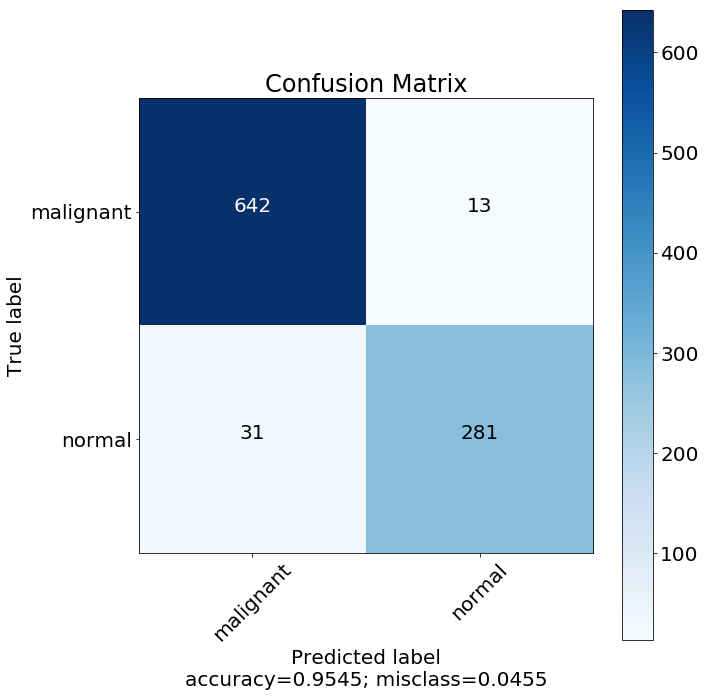

In [25]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/17.Ensemble-Models1-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,title='Confusion Matrix')

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[642  13]
 [ 31 281]]
             precision    recall  f1-score   support

  malignant       0.95      0.98      0.97       655
     normal       0.96      0.90      0.93       312

avg / total       0.95      0.95      0.95       967



In [27]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  95.44984488107549
Sensitivity :  95.39375928677563
Specificity :  95.578231292517


In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc*100))
print('Precision: {:.4f}'.format(prec*100))
print('Recall:    {:.4f}'.format(recall*100))
print('F1:        {:.4f}'.format(f1*100))

Accuracy:  95.4498
Precision: 95.5782
Recall:    90.0641
F1:        92.7393


In [36]:
test_dir = "C-NMC_phase_2_data/"

In [37]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode=None)

Found 1867 images belonging to 1 classes.


In [38]:
predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)

234/233 [==============================] - 32s 137ms/step


In [69]:
predicts

array([[0.9979432 , 0.00205677],
       [0.9979432 , 0.00205676],
       [0.9979432 , 0.00205676],
       ...,
       [0.99794275, 0.00205724],
       [0.997943  , 0.00205695],
       [0.9979431 , 0.00205689]], dtype=float32)

In [44]:
import pandas as pd
# Extract test names from test_generator
# test_names = [name.split(".")[0] for name in test_generator.filenames]
test_names = [name.split("\\")[1].split(".")[0] for name in test_generator.filenames] # For windows OS

# Create a dataframe
df_pred_test = pd.DataFrame(test_names, columns=["id"])

# !!! label == probability of true positive (has cancer) !!!
df_pred_test["label"] = pd.DataFrame(predicts[:,1])

df_pred_test.head()

,id,label
0,1,0.002057
1,10,0.002057
2,100,0.002057
3,1000,0.002057
4,1001,0.002060


In [51]:
submission = pd.DataFrame(df_pred_test)

In [52]:
submission.head()

,id,label
0,1,0.002057
1,10,0.002057
2,100,0.002057
3,1000,0.002057
4,1001,0.002060


In [61]:
submission.to_csv("submission.csv", index = False, header = True)

In [62]:
df = pd.read_csv("submission.csv")
df.head()

,id,label
0,1,0.002057
1,10,0.002057
2,100,0.002057
3,1000,0.002057
4,1001,0.002060


In [67]:
submission2= df.sort_values(by=['id'])
label = submission2["label"]
label.head()

0       0.002057
979     0.002057
1090    0.002062
1201    0.714720
1312    0.002058
Name: label, dtype: float64

In [68]:
label.to_csv("label.csv", index = False, header = True)

In [102]:
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

predictions = []
files = [name for name in os.listdir('C-NMC_phase_2_data/test_set/')]
for file in files:
    original = load_img('C-NMC_phase_2_data/test_set/' + file, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    processed_image = vgg16.preprocess_input(image_batch)  # you dont need to copy :)      
    predictions_cur = model.predict(processed_image)
    print(predictions_cur)
    predictions.append(predictions_cur)

[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.7387047  0.26129523]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.7387047  0.26129523]]
[[0.9979432  0.00205676]]
[[0.7387047  0.26129523]]
[[0.7387047  0.26129523]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.7387047  0.26129523]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432  0.00205676]]
[[0.9979432 

KeyboardInterrupt: 

In [114]:
files = [name for name in os.listdir('C-NMC_phase_2_data/test_set')]
for file in files:
    print ('C-NMC_phase_2_data/test_set/' + file)

C-NMC_phase_2_data/test_set/1.jpg
C-NMC_phase_2_data/test_set/10.jpg
C-NMC_phase_2_data/test_set/100.jpg
C-NMC_phase_2_data/test_set/1000.jpg
C-NMC_phase_2_data/test_set/1001.jpg
C-NMC_phase_2_data/test_set/1002.jpg
C-NMC_phase_2_data/test_set/1003.jpg
C-NMC_phase_2_data/test_set/1004.jpg
C-NMC_phase_2_data/test_set/1005.jpg
C-NMC_phase_2_data/test_set/1006.jpg
C-NMC_phase_2_data/test_set/1007.jpg
C-NMC_phase_2_data/test_set/1008.jpg
C-NMC_phase_2_data/test_set/1009.jpg
C-NMC_phase_2_data/test_set/101.jpg
C-NMC_phase_2_data/test_set/1010.jpg
C-NMC_phase_2_data/test_set/1011.jpg
C-NMC_phase_2_data/test_set/1012.jpg
C-NMC_phase_2_data/test_set/1013.jpg
C-NMC_phase_2_data/test_set/1014.jpg
C-NMC_phase_2_data/test_set/1015.jpg
C-NMC_phase_2_data/test_set/1016.jpg
C-NMC_phase_2_data/test_set/1017.jpg
C-NMC_phase_2_data/test_set/1018.jpg
C-NMC_phase_2_data/test_set/1019.jpg
C-NMC_phase_2_data/test_set/102.jpg
C-NMC_phase_2_data/test_set/1020.jpg
C-NMC_phase_2_data/test_set/1021.jpg
C-NMC_pha

In [127]:
files = [name for name in os.listdir('C-NMC_phase_2_data/test_set')]
for file in files:
    filename= 'C-NMC_phase_2_data/test_set'+file
    print(filename)

C-NMC_phase_2_data/test_set1.jpg
C-NMC_phase_2_data/test_set10.jpg
C-NMC_phase_2_data/test_set100.jpg
C-NMC_phase_2_data/test_set1000.jpg
C-NMC_phase_2_data/test_set1001.jpg
C-NMC_phase_2_data/test_set1002.jpg
C-NMC_phase_2_data/test_set1003.jpg
C-NMC_phase_2_data/test_set1004.jpg
C-NMC_phase_2_data/test_set1005.jpg
C-NMC_phase_2_data/test_set1006.jpg
C-NMC_phase_2_data/test_set1007.jpg
C-NMC_phase_2_data/test_set1008.jpg
C-NMC_phase_2_data/test_set1009.jpg
C-NMC_phase_2_data/test_set101.jpg
C-NMC_phase_2_data/test_set1010.jpg
C-NMC_phase_2_data/test_set1011.jpg
C-NMC_phase_2_data/test_set1012.jpg
C-NMC_phase_2_data/test_set1013.jpg
C-NMC_phase_2_data/test_set1014.jpg
C-NMC_phase_2_data/test_set1015.jpg
C-NMC_phase_2_data/test_set1016.jpg
C-NMC_phase_2_data/test_set1017.jpg
C-NMC_phase_2_data/test_set1018.jpg
C-NMC_phase_2_data/test_set1019.jpg
C-NMC_phase_2_data/test_set102.jpg
C-NMC_phase_2_data/test_set1020.jpg
C-NMC_phase_2_data/test_set1021.jpg
C-NMC_phase_2_data/test_set1022.jpg


In [134]:
import cv2
files = [name for name in os.listdir('C-NMC_phase_2_data/test_set')]
for file in files:
    filename= 'C-NMC_phase_2_data/test_set'+file
    print(filename)


test_images = []

for file_path in files:
    #read image
    filename= 'C-NMC_phase_2_data/test_set/'+file_path
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224))
#     #resize
#     if(img.shape[0] > img.shape[1]):
#         tile_size = (int(img.shape[1]*256/img.shape[0]),256)
#     else:
#         tile_size = (256, int(img.shape[0]*256/img.shape[1]))


    

    test_images.append(img)
    
#     path, ext = os.path.splitext( os.path.basename(file_paths[0]) )

test_images = np.array(test_images)

C-NMC_phase_2_data/test_set1.jpg
C-NMC_phase_2_data/test_set10.jpg
C-NMC_phase_2_data/test_set100.jpg
C-NMC_phase_2_data/test_set1000.jpg
C-NMC_phase_2_data/test_set1001.jpg
C-NMC_phase_2_data/test_set1002.jpg
C-NMC_phase_2_data/test_set1003.jpg
C-NMC_phase_2_data/test_set1004.jpg
C-NMC_phase_2_data/test_set1005.jpg
C-NMC_phase_2_data/test_set1006.jpg
C-NMC_phase_2_data/test_set1007.jpg
C-NMC_phase_2_data/test_set1008.jpg
C-NMC_phase_2_data/test_set1009.jpg
C-NMC_phase_2_data/test_set101.jpg
C-NMC_phase_2_data/test_set1010.jpg
C-NMC_phase_2_data/test_set1011.jpg
C-NMC_phase_2_data/test_set1012.jpg
C-NMC_phase_2_data/test_set1013.jpg
C-NMC_phase_2_data/test_set1014.jpg
C-NMC_phase_2_data/test_set1015.jpg
C-NMC_phase_2_data/test_set1016.jpg
C-NMC_phase_2_data/test_set1017.jpg
C-NMC_phase_2_data/test_set1018.jpg
C-NMC_phase_2_data/test_set1019.jpg
C-NMC_phase_2_data/test_set102.jpg
C-NMC_phase_2_data/test_set1020.jpg
C-NMC_phase_2_data/test_set1021.jpg
C-NMC_phase_2_data/test_set1022.jpg


In [135]:
test_images = test_images.astype('float32')
test_images /= 255

In [136]:
predictions = model.predict(test_images)

In [137]:
predictions

array([[0.9979432 , 0.00205677],
       [0.9979432 , 0.00205676],
       [0.9979432 , 0.00205676],
       ...,
       [0.9979431 , 0.0020569 ],
       [0.9979426 , 0.00205734],
       [0.9979424 , 0.00205761]], dtype=float32)